In [485]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import re

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [86]:
#specify the columns to use
cols_use_load = ['Date', 'Hour', 'DA_DEMD', 'DryBulb', 'DewPnt', 'Day']
cols_use_price = ['Date', 'Hour', 'DA_DEMD', 'DryBulb', 'DewPnt', 'DA_LMP', 'Day', 'DA_EC', 'DA_CC', 'DA_MLC']

### Load Data

In [87]:
#2012-14 dataset
data1 = pd.read_csv('loadData1.csv', usecols=cols_use_price, skiprows=range(1415,1439))
data2 = pd.read_csv('loadData2.csv', usecols=cols_use_price)
data3 = pd.read_csv('loadData3.csv', usecols=cols_use_price)

### Feature Engineering

In [88]:
#functions for converting string to datetime objects
def convert_string_to_datetime(string):
    datetime_obj = datetime.strptime(string, "%d-%b-%y")
    return datetime_obj.date()

#format is different for 2012,2013,2014
def convert_string_to_datetime2(string):
    datetime_obj = datetime.strptime(string, "%m/%d/%Y")
    return datetime_obj.date()

#format is different for 2015
def convert_string_to_datetime3(string):
    datetime_obj = datetime.strptime(string, "%d/%m/%Y")
    return datetime_obj.date()

#format for natural Gas prices
def convert_string_to_datetime4(string):
    datetime_obj = datetime.strptime(string, "%Y-%m-%d")
    return datetime_obj.date()

In [89]:
#append year wise data together to one single file
tot_data = data1.append([data2], ignore_index=True)

In [90]:
tot_data['Date'] = tot_data['Date'].apply(convert_string_to_datetime2)
tot_data['Date'] = pd.to_datetime(tot_data['Date'])

In [91]:
#function to get day from date
def get_day_from_date(date_time_obj):
    return int(date_time_obj.date().day)

#function to get month from date
def get_month_from_date(date_time_obj):
    return int(date_time_obj.date().month)

In [92]:
tot_data['Day_Date'] = tot_data['Date'].apply(get_day_from_date)

In [93]:
tot_data.head()

,Date,Hour,DA_DEMD,DA_LMP,DA_EC,DA_CC,DA_MLC,DryBulb,DewPnt,Day,Day_Date
0,2012-01-01,1,10711.0,35.12,35.22,0.0,-0.10,35,33,1,1
1,2012-01-01,2,10276.0,33.38,33.39,0.0,-0.01,35,33,1,1
2,2012-01-01,3,9868.0,30.26,30.30,0.0,-0.04,36,33,1,1
3,2012-01-01,4,9771.0,28.88,28.88,0.0,0.00,36,33,1,1
4,2012-01-01,5,9884.0,20.23,20.21,0.0,0.02,36,33,1,1


#### Add Target Labels - Next Hour Data

In [94]:
tot_data_labels = list(tot_data['DA_LMP'][1:])
tot_data_labels.append(data3['DA_LMP'][0])

In [95]:
tot_data = tot_data.reset_index(drop=True)
print("Done")

Done


In [96]:
tot_data['TARGET_DA_LMP'] = tot_data_labels

#### Add previous day same hour price
This should be more useful for very short term than prev week

In [97]:
prev_day_da_lmp_targ = tot_data['DA_LMP'][1:-24]
prev_day_da_lmp_targ = prev_day_da_lmp_targ.reset_index(drop=True)

prev_day_da_demd_targ = tot_data['DA_DEMD'][1:-24]
prev_day_da_demd_targ = prev_day_da_demd_targ.reset_index(drop=True)

prev_day_dry_bulb_targ = tot_data['DryBulb'][1:-24]
prev_day_dry_bulb_targ = prev_day_dry_bulb_targ.reset_index(drop=True)

temp_df = pd.DataFrame({
    'prev_day_da_lmp': prev_day_da_lmp_targ,
    'prev_day_da_demd': prev_day_da_demd_targ,
    'prev_day_dry_bulb': prev_day_dry_bulb_targ,
    'actual_da_lmp': tot_data['DA_LMP'][0:-25],
    'actual_da_demd': tot_data['DA_DEMD'][0:-25],
    'actual_dry_bulb': tot_data['DryBulb'][0:-25]
})

temp_df['chg_in_da_demd'] = temp_df['actual_da_demd'] - temp_df['prev_day_da_demd']
temp_df['chg_in_dry_bulb'] = temp_df['actual_dry_bulb'] - temp_df['prev_day_dry_bulb']
temp_df['chg_in_da_lmp'] = temp_df['actual_da_lmp'] - temp_df['prev_day_da_lmp']

In [98]:
tot_data = tot_data[24:-1]
tot_data = tot_data.reset_index(drop=True)

In [99]:
tot_data = pd.merge(tot_data, temp_df[['prev_day_da_demd','prev_day_da_lmp', 'prev_day_dry_bulb',
                           'chg_in_da_demd', 'chg_in_da_lmp', 'chg_in_dry_bulb']], how='inner', 
                    left_index=True, right_index=True)
len(tot_data)

17495

#### Add Previous Week Next Hour Data
Maybe useful for short-term, not so much for very short term forecasting

#### Add daily means to the data

In [100]:
mean_values = tot_data.groupby('Date', as_index=False).mean()[['Date','DA_DEMD', 'DA_LMP', 'DryBulb', 'DewPnt']]
temp = pd.merge(tot_data, mean_values, how='inner', left_on='Date', right_on='Date', 
                suffixes=('_actual_value','_daily_mean'))
tot_data = temp

#### Add crude oil prices

In [101]:
crude_oil = pd.read_csv('CurdeOil.csv', delimiter='\t')
crude_oil = crude_oil[::-1]
crude_oil = crude_oil.reset_index(drop=True)
crude_oil = crude_oil[2:]
crude_oil = crude_oil.reset_index(drop=True)

def get_num_from_vol_str(string):
    match = re.search(r"(\d+)", string)
    if match!=None:
        return float(match.group(1))
    
crude_oil = crude_oil[['Date', 'Price', 'Vol.']]
crude_oil['Date'] = crude_oil['Date'].apply(convert_string_to_datetime)
crude_oil['Date'] = pd.to_datetime(crude_oil['Date'])

crude_oil['Crude_Oil_Price'] = crude_oil['Price']
crude_oil['Crude_Oil_Vol'] = crude_oil['Vol.']

crude_oil = crude_oil.drop('Price', axis=1)
crude_oil = crude_oil.drop('Vol.', axis=1)

temp = pd.merge(tot_data, crude_oil, how='outer', left_on='Date', right_on='Date', suffixes=('_X','_crude_oil'))
temp.reset_index(drop=True)
temp['Crude_Oil_Price'] = temp['Crude_Oil_Price'].fillna(method='bfill')
temp['Crude_Oil_Vol'] = temp['Crude_Oil_Vol'].fillna(method='bfill')
temp = temp[0:len(tot_data)]
tot_data = temp

tot_data['Crude_Oil_Vol'] = tot_data['Crude_Oil_Vol'].apply(get_num_from_vol_str)

'''
temp2 = pd.merge(test, crude_oil, how='outer', left_on='Date', right_on='Date', suffixes=('_X','_crude_oil'))
temp2.reset_index(drop=True)
temp2['Crude_Oil_Price'] = temp2['Crude_Oil_Price'].fillna(method='bfill')
temp2['Crude_Oil_Vol'] = temp2['Crude_Oil_Vol'].fillna(method='bfill')
test = temp2[0:4271]

test['Crude_Oil_Vol'] = test['Crude_Oil_Vol'].apply(get_num_from_vol_str)
'''

"\ntemp2 = pd.merge(test, crude_oil, how='outer', left_on='Date', right_on='Date', suffixes=('_X','_crude_oil'))\ntemp2.reset_index(drop=True)\ntemp2['Crude_Oil_Price'] = temp2['Crude_Oil_Price'].fillna(method='bfill')\ntemp2['Crude_Oil_Vol'] = temp2['Crude_Oil_Vol'].fillna(method='bfill')\ntest = temp2[0:4271]\n\ntest['Crude_Oil_Vol'] = test['Crude_Oil_Vol'].apply(get_num_from_vol_str)\n"

#### Add Natural Gas Price

In [102]:
natural_gas = pd.read_csv('natural_gas.csv')

In [103]:
natural_gas.tail()

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
750,2012-01-09,3.011,3.032,2.977,3.011,NaN,3.011,115212.0,165717.0
751,2012-01-06,2.960,3.077,2.955,3.062,NaN,3.062,132139.0,172208.0
752,2012-01-05,3.122,3.123,2.947,2.980,NaN,2.980,171870.0,171072.0
753,2012-01-04,2.978,3.123,2.975,3.096,NaN,3.096,137309.0,173289.0
754,2012-01-03,2.969,3.074,2.936,2.993,NaN,2.993,110030.0,180477.0


In [104]:
natural_gas['Date'] = natural_gas['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

In [105]:
natural_gas.rename(columns={
    'Open': 'Natural_Gas_Price_Open',
    'Last': 'Natural_Gas_Price_Close'
}, inplace=True)

In [106]:
natural_gas['Date'] = pd.to_datetime(natural_gas['Date'])

In [107]:
tot_data = pd.merge(left=tot_data, right=natural_gas[['Date', 'Natural_Gas_Price_Open', 'Natural_Gas_Price_Close']],
        how='left', on='Date')

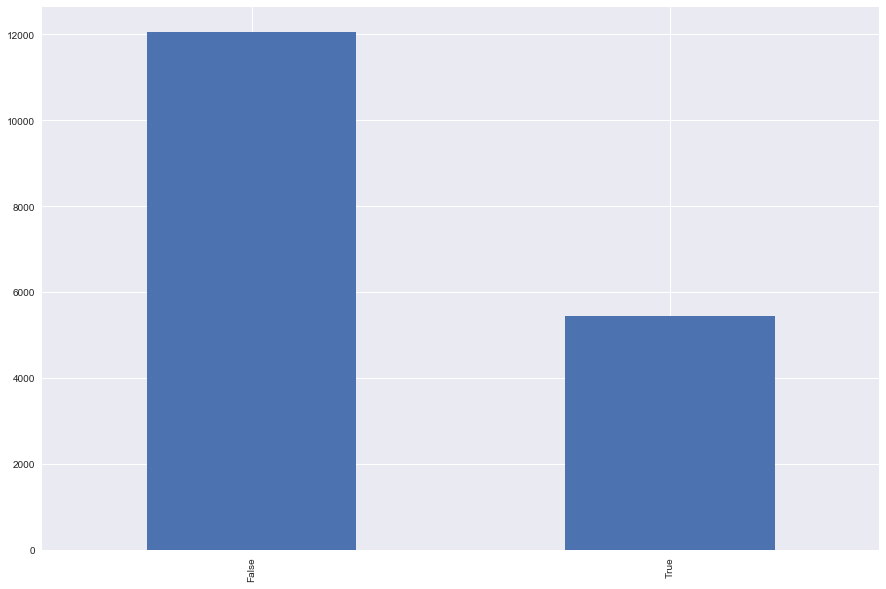

In [108]:
tot_data['Natural_Gas_Price_Open'].isnull().value_counts().plot(kind='bar')

In [109]:
tot_data.fillna(method='bfill', inplace=True)

In [110]:
tot_data.head()

,Date,Hour,DA_DEMD_actual_value,DA_LMP_actual_value,DA_EC,DA_CC,DA_MLC,DryBulb_actual_value,DewPnt_actual_value,Day,...,chg_in_da_lmp,chg_in_dry_bulb,DA_DEMD_daily_mean,DA_LMP_daily_mean,DryBulb_daily_mean,DewPnt_daily_mean,Crude_Oil_Price,Crude_Oil_Vol,Natural_Gas_Price_Open,Natural_Gas_Price_Close
0,2012-01-02,1.0,10453.0,30.36,30.24,0.0,0.12,47.0,44.0,2.0,...,1.74,0.0,13152.291667,44.879167,39.375,25.708333,102.96,275.0,2.969,2.993
1,2012-01-02,2.0,10447.0,30.95,30.80,0.0,0.15,47.0,44.0,2.0,...,3.12,-1.0,13152.291667,44.879167,39.375,25.708333,102.96,275.0,2.969,2.993
2,2012-01-02,3.0,10446.0,24.05,23.86,0.0,0.19,47.0,44.0,2.0,...,1.38,0.0,13152.291667,44.879167,39.375,25.708333,102.96,275.0,2.969,2.993
3,2012-01-02,4.0,10374.0,20.49,20.34,0.0,0.15,46.0,42.0,2.0,...,8.65,0.0,13152.291667,44.879167,39.375,25.708333,102.96,275.0,2.969,2.993
4,2012-01-02,5.0,10473.0,20.46,20.34,0.0,0.12,43.0,37.0,2.0,...,-0.03,1.0,13152.291667,44.879167,39.375,25.708333,102.96,275.0,2.969,2.993


In [111]:
tot_data.to_csv('final_complete_data.csv', index=False)

 # Load the Data
 just load the saved csv
 no need to run the previous blocks again

In [970]:
tot_data = pd.read_csv('../final_complete_data.csv')

In [971]:
tot_data.head()

,Date,Hour,DA_DEMD_actual_value,DA_LMP_actual_value,DA_EC,DA_CC,DA_MLC,DryBulb_actual_value,DewPnt_actual_value,Day,...,chg_in_da_lmp,chg_in_dry_bulb,DA_DEMD_daily_mean,DA_LMP_daily_mean,DryBulb_daily_mean,DewPnt_daily_mean,Crude_Oil_Price,Crude_Oil_Vol,Natural_Gas_Price_Open,Natural_Gas_Price_Close
0,2012-01-02,1.0,10453.0,30.36,30.24,0.0,0.12,47.0,44.0,2.0,...,1.74,0.0,13152.291667,44.879167,39.375,25.708333,102.96,275.0,2.969,2.993
1,2012-01-02,2.0,10447.0,30.95,30.80,0.0,0.15,47.0,44.0,2.0,...,3.12,-1.0,13152.291667,44.879167,39.375,25.708333,102.96,275.0,2.969,2.993
2,2012-01-02,3.0,10446.0,24.05,23.86,0.0,0.19,47.0,44.0,2.0,...,1.38,0.0,13152.291667,44.879167,39.375,25.708333,102.96,275.0,2.969,2.993
3,2012-01-02,4.0,10374.0,20.49,20.34,0.0,0.15,46.0,42.0,2.0,...,8.65,0.0,13152.291667,44.879167,39.375,25.708333,102.96,275.0,2.969,2.993
4,2012-01-02,5.0,10473.0,20.46,20.34,0.0,0.12,43.0,37.0,2.0,...,-0.03,1.0,13152.291667,44.879167,39.375,25.708333,102.96,275.0,2.969,2.993


#### Helper Functions

In [972]:
tot_data['Date'] = tot_data['Date'].apply(convert_string_to_datetime4)
tot_data['Date'] = pd.to_datetime(tot_data['Date'])

In [973]:
tot_data.columns.values

array(['Date', 'Hour', 'DA_DEMD_actual_value', 'DA_LMP_actual_value',
       'DA_EC', 'DA_CC', 'DA_MLC', 'DryBulb_actual_value',
       'DewPnt_actual_value', 'Day', 'Day_Date', 'TARGET_DA_LMP',
       'prev_day_da_demd', 'prev_day_da_lmp', 'prev_day_dry_bulb',
       'chg_in_da_demd', 'chg_in_da_lmp', 'chg_in_dry_bulb',
       'DA_DEMD_daily_mean', 'DA_LMP_daily_mean', 'DryBulb_daily_mean',
       'DewPnt_daily_mean', 'Crude_Oil_Price', 'Crude_Oil_Vol',
       'Natural_Gas_Price_Open', 'Natural_Gas_Price_Close'], dtype=object)

In [979]:
tot_data['Month'] = tot_data['Date'].apply(lambda x: x.month)
tot_data['Week'] = tot_data['Date'].apply(lambda x: x.week)

#### Deal with -ve target values

In [980]:
X = tot_data

In [981]:
for i in range(len(X['TARGET_DA_LMP'])):
    if(X['TARGET_DA_LMP'][i] < 1):
        X['TARGET_DA_LMP'][i] = (X['TARGET_DA_LMP'][i-1]+X['TARGET_DA_LMP'][i+1])/2

/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Date Time Index

In [982]:
X.set_index(['Date'], drop=True, inplace=True)

In [983]:
X.head()

,Hour,DA_DEMD_actual_value,DA_LMP_actual_value,DA_EC,DA_CC,DA_MLC,DryBulb_actual_value,DewPnt_actual_value,Day,Day_Date,...,DA_DEMD_daily_mean,DA_LMP_daily_mean,DryBulb_daily_mean,DewPnt_daily_mean,Crude_Oil_Price,Crude_Oil_Vol,Natural_Gas_Price_Open,Natural_Gas_Price_Close,Month,Week
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-02,1.0,10453.0,30.36,30.24,0.0,0.12,47.0,44.0,2.0,2.0,...,13152.291667,44.879167,39.375,25.708333,102.96,275.0,2.969,2.993,1,1
2012-01-02,2.0,10447.0,30.95,30.80,0.0,0.15,47.0,44.0,2.0,2.0,...,13152.291667,44.879167,39.375,25.708333,102.96,275.0,2.969,2.993,1,1
2012-01-02,3.0,10446.0,24.05,23.86,0.0,0.19,47.0,44.0,2.0,2.0,...,13152.291667,44.879167,39.375,25.708333,102.96,275.0,2.969,2.993,1,1
2012-01-02,4.0,10374.0,20.49,20.34,0.0,0.15,46.0,42.0,2.0,2.0,...,13152.291667,44.879167,39.375,25.708333,102.96,275.0,2.969,2.993,1,1
2012-01-02,5.0,10473.0,20.46,20.34,0.0,0.12,43.0,37.0,2.0,2.0,...,13152.291667,44.879167,39.375,25.708333,102.96,275.0,2.969,2.993,1,1


#### ------------- DATA PREP OVER --------------------

## FEATURE IMPORTANCE STUDY

In [984]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

#function to calculate mape
def mean_absolute_percentage_error(y_pred, y_true): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def point_absolute_percentage_error(y_pred, y_true):
    return np.abs((y_true - y_pred) / y_true) * 100

#GIVE Everything you can imagine of function - SD, VAR, MIN and MAX ERROR, CI
def get_CI_VAR_SD(error_list):
    t = stats.t.ppf(1-0.025, len(error_list)-1)
    max_err = np.mean(error_list) + (t * (np.std(error_list)/np.sqrt(len(error_list))))
    min_err = np.mean(error_list) - (t * (np.std(error_list)/np.sqrt(len(error_list))))
    ci = ((max_err - np.mean(error_list))/np.mean(error_list))*100
    sd = np.std(error_list)
    var = np.var(error_list)
    return (max_err, min_err, ci, sd, var)

In [985]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression

In [986]:
train_feature_imp = X[X.Day_Date<24]
test_feature_imp = X[X.Day_Date>=24]

#train1 = train.query('Day_Date < 2')
#train2 = train.query('Day_Date > 9 & Day_Date < 12')
#train3 = train.query('Day_Date > 18 & Day_Date < 22')
#train = train1.append(train2)
#train = train.append(train3)
#test = test1.append(test2)

train_feature_imp = train_feature_imp.reset_index(drop=True)
test_fetaur_imp = test_feature_imp.reset_index(drop=True)

print(len(train_feature_imp))
print(len(test_feature_imp))

13224
4271


In [987]:
train_feature_imp.head()

,Hour,DA_DEMD_actual_value,DA_LMP_actual_value,DA_EC,DA_CC,DA_MLC,DryBulb_actual_value,DewPnt_actual_value,Day,Day_Date,...,DA_DEMD_daily_mean,DA_LMP_daily_mean,DryBulb_daily_mean,DewPnt_daily_mean,Crude_Oil_Price,Crude_Oil_Vol,Natural_Gas_Price_Open,Natural_Gas_Price_Close,Month,Week
0,1.0,10453.0,30.36,30.24,0.0,0.12,47.0,44.0,2.0,2.0,...,13152.291667,44.879167,39.375,25.708333,102.96,275.0,2.969,2.993,1,1
1,2.0,10447.0,30.95,30.80,0.0,0.15,47.0,44.0,2.0,2.0,...,13152.291667,44.879167,39.375,25.708333,102.96,275.0,2.969,2.993,1,1
2,3.0,10446.0,24.05,23.86,0.0,0.19,47.0,44.0,2.0,2.0,...,13152.291667,44.879167,39.375,25.708333,102.96,275.0,2.969,2.993,1,1
3,4.0,10374.0,20.49,20.34,0.0,0.15,46.0,42.0,2.0,2.0,...,13152.291667,44.879167,39.375,25.708333,102.96,275.0,2.969,2.993,1,1
4,5.0,10473.0,20.46,20.34,0.0,0.12,43.0,37.0,2.0,2.0,...,13152.291667,44.879167,39.375,25.708333,102.96,275.0,2.969,2.993,1,1


In [988]:
cols_feature_imp = X.columns.difference(['TARGET_DA_LMP']).values

In [1074]:
cols_feature_imp2 = ['DA_LMP_actual_value', 'chg_in_da_demd', 'chg_in_da_lmp', 'prev_day_da_lmp', 'DA_LMP_daily_mean',
 'Hour', 'DA_DEMD_actual_value', 'DryBulb_actual_value', 'DryBulb_daily_mean', 
 'Crude_Oil_Price', 'Day', 'Day_Date', 'Month']

In [1075]:
train_feature_imp_x = train_feature_imp[cols_feature_imp2]
train_feature_imp_y = pd.DataFrame(train_feature_imp['TARGET_DA_LMP'])
test_feature_imp_x = test_feature_imp[cols_feature_imp2]
test_feature_imp_y = pd.DataFrame(test_feature_imp['TARGET_DA_LMP'])

In [1076]:
scaler = StandardScaler()
train_feature_imp_scaled = scaler.fit_transform(train_feature_imp_x)
test_feature_imp_scaled = scaler.fit_transform(test_feature_imp_x)

##### ElasticNet

In [1101]:
enet_model = ElasticNet(alpha=4, l1_ratio=0.3)
enet_model = enet_model.fit(train_feature_imp_scaled, train_feature_imp_y)
enet_model.coef_

array([ 5.96752604, -0.24823747, -0.2916021 ,  4.91557576,  5.28167857,
        0.20738785,  2.0982742 , -0.94089719, -1.30794027, -0.        ,
       -0.        ,  0.        , -0.        ])

##### Mutual Info

In [1078]:
mutual_info = mutual_info_regression(train_feature_imp_scaled, train_feature_imp_y.values, n_neighbors=100,
                                    random_state=333)

/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [1079]:
mutual_info

array([ 1.45784602,  0.01801191,  0.09031685,  0.85133752,  0.67403433,
        0.14149557,  0.30681221,  0.26296614,  0.25295537,  0.14922877,
        0.01919782,  0.02995272,  0.17757246])

##### Plots
<code>
['DA_LMP_actual_value', 'chg_in_da_demd', 'chg_in_da_lmp', 'prev_day_da_lmp', 'DA_LMP_daily_mean',
 'Hour', 'DA_DEMD_actual_value', 'DryBulb_actual_value', 'DryBulb_daily_mean', 
 'Crude_Oil_Price']
</code>
<br>
<code>
['Previous Hour DA LMP', 'Previous Day Change in DA DEMAND', 'Previous Day Change in DA LMP', 'Previous Day DA LMP',
 'Daily Average DA LMP', 'Hour Indicator', 'Previous Hour DA DEMAND', 'Hourly Dry Bulb Temp', 
 'Daily Average Dry Bulb Temp', 'Crude Oil Prices', 'Weekday Indicator', 'Date Part Day Indicator', 'Month Indicator']
</code>


In [1080]:
sanitised_colnames_set = tuple(['Previous Hour DA LMP', 'Previous Day Change in DA DEMAND', 
                                'Previous Day Change in DA LMP', 'Previous Day DA LMP',
 'Daily Average DA LMP', 'Hour Indicator', 'Previous Hour DA DEMAND', 'Hourly Dry Bulb Temp', 
 'Daily Average Dry Bulb Temp', 'Crude Oil Prices', 'Weekday Indicator', 
                                'Date Part Day Indicator', 'Month Indicator'])

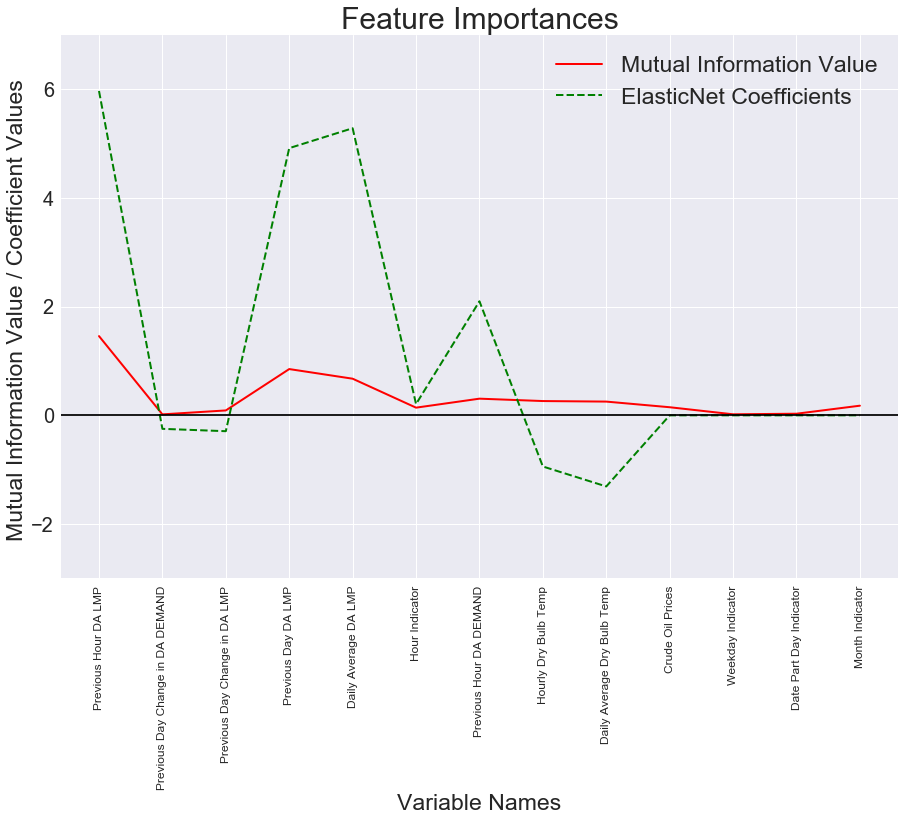

In [1109]:
#plt.plot(lasso_model.coef_, linewidth=2, linestyle='--', label='LASSO', color='blue')
plt.plot(mutual_info, linewidth=2, linestyle='-', label='Mutual Information Value', color='red')
plt.plot(enet_model.coef_, linewidth=2, linestyle='--', label='ElasticNet Coefficients', color='green')
plt.ylim(-3, 7)
plt.xticks(np.arange(len(train_feature_imp_x.columns.values)), 
           sanitised_colnames_set, rotation=90, fontsize=12)
plt.axhline(y=0, color='black')
plt.xlabel("Variable Names", {'fontsize':23})
plt.ylabel("Mutual Information Value / Coefficient Values ",{'fontsize':23})
plt.yticks(fontsize=20, rotation=0)
plt.title("Feature Importances", {'fontsize':30})
plt.legend(loc=1, fontsize=23)
plt.gcf()
plt.savefig("../NEWPLOTS_Feb19/FeatureImportancePlot.jpg", format='jpg', bbox_inches='tight', dpi=600)